# CHE1148 Assignment 1
## Task #2: Plot the profile rates per 1M residents
## cumulative mortality rate per 1M

In [1]:
import pandas as pd
import glob
import os
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from adjustText import adjust_text
from matplotlib.ticker import ScalarFormatter

C:\Programing_Language\Anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# READ CUMULATIVE TABLE
covid_cumulative = pd.read_excel("covid_a_master_cumulative_table.xlsx", index_col= 0)

# This part is necessary instead of simply ['Date'].max() because some countries do not report on certain days (e.g. Spain on Sundays) -- FIXED BUG
last_day_per_country = covid_cumulative.groupby(by=['Countries'])['Date'].max() # type(last_day_per_country) is pandas.Series
last_day_per_country = last_day_per_country.to_frame() # We convert it to pandas.DataFrame
last_day_per_country.reset_index(inplace=True) # And reset the index so that we can further join on 'Countries'

# N: HOW MANY TOP COUNTRIES YOU WANT TO PICK IN TERMS OF # OF CASES
N = 20
last_day = pd.merge(covid_cumulative, last_day_per_country, how='inner', left_on = ['Countries', 'Date'], right_on = ['Countries', 'Date'])
last_day['Cases\_per\_1m'] = last_day['Cases']/last_day['Population']*1000000
last_day['Deaths\_per\_1m'] = last_day['Deaths']/last_day['Population']*1000000
last_day = last_day.sort_values('Deaths\_per\_1m', ascending=False)
last_day
top_countries = last_day[:N]['Countries'].tolist()


# K: HOW MANY DEATHS YOU CONSIDER THE DAY 0
K = 0
covid_top_countries_Day0_from_death_exceed_10 = covid_cumulative[covid_cumulative.Countries.isin(top_countries)]
covid_top_countries_Day0_from_death_exceed_10 = covid_top_countries_Day0_from_death_exceed_10[covid_top_countries_Day0_from_death_exceed_10['Deaths'] > K]

# FIND THE DATE THAT THE FIRST K DEATH WERE IDENTIFIED
day_0_for_every_country = covid_top_countries_Day0_from_death_exceed_10.groupby(by=['Countries']).min()
day_0_for_every_country = day_0_for_every_country['Date']

# MERGE THE TWO TO GET THE DAY_0 IN THE df, AND CALCULATE THE DAYS_FROM_0
covid_top_countries_Day0_from_death_exceed_10 = covid_top_countries_Day0_from_death_exceed_10.merge(day_0_for_every_country, how='inner', on='Countries')
covid_top_countries_Day0_from_death_exceed_10.rename(columns = {'Date_y': 'Day_0'}, inplace = True)
covid_top_countries_Day0_from_death_exceed_10['Days_from_0'] = (covid_top_countries_Day0_from_death_exceed_10['Date_x'] - covid_top_countries_Day0_from_death_exceed_10['Day_0']).dt.days

In [3]:
death_rate = pd.read_excel('Death_rate_crude_per_1000_people.xls',
                           sheet_name = 'Data',
                           header = 3,
                           index_col = 0)\
                           .drop(columns=['Country Code','Indicator Name','Indicator Code'])
death_rate = death_rate.ffill(axis=1).iloc[:,-1]
death_rate = death_rate.to_frame(name = "Death rate per 1000")
death_rate['Countries'] = death_rate.index
death_rate.replace('United States','USA',inplace=True)
death_rate.replace('United Kingdom','UK',inplace=True)
death_rate.replace('Korea, Rep','S.Korea',inplace=True)
death_rate.replace('Iran, Islamic Rep.','Iran',inplace=True)
death_rate.replace('Saudi Arabia','S.Arabia',inplace=True)
death_rate.replace('South Africa','S.Africa',inplace=True)


In [4]:
df = covid_top_countries_Day0_from_death_exceed_10.merge(death_rate, on='Countries', how='left')
df

,Cases,Deaths,Date_x,Countries,Population,Continent,Day_0,Days_from_0,Death rate per 1000
0,11,1,2020-02-15,France,67012883.0,Europe,2020-02-15,0,9.0
1,11,1,2020-02-16,France,67012883.0,Europe,2020-02-15,1,9.0
2,12,1,2020-02-17,France,67012883.0,Europe,2020-02-15,2,9.0
3,12,1,2020-02-18,France,67012883.0,Europe,2020-02-15,3,9.0
4,12,1,2020-02-19,France,67012883.0,Europe,2020-02-15,4,9.0
...,...,...,...,...,...,...,...,...,...
3357,368,17,2020-08-23,Sint_Maarten,42389.0,America,2020-04-02,143,NaN
3358,396,17,2020-08-24,Sint_Maarten,42389.0,America,2020-04-02,144,NaN
3359,408,17,2020-08-25,Sint_Maarten,42389.0,America,2020-04-02,145,NaN
3360,418,17,2020-08-26,Sint_Maarten,42389.0,America,2020-04-02,146,NaN


In [5]:
df['Deaths_per_1m'] = df['Deaths']/df['Population']* 1000000

In [6]:
#cumulative_mortality_rate_per_1M_order = pd.DataFrame(columns=['Countries','max_Deaths_per_1m'])
#i = 0
#for country in top_countries:
#    cumulative_mortality_rate_per_1M_order.loc[i]=[country,max(df[df['Countries']==country]['Deaths_per_1m'])]
#    i=i+1   
#cumulative_mortality_rate_per_1M_order=cumulative_mortality_rate_per_1M_order.sort_values(by='max_Deaths_per_1m',ascending=False)

cumulative_mortality_rate_per_1M_order=top_countries

In [7]:
data_1_5_deaths = df[df.Countries.isin(cumulative_mortality_rate_per_1M_order[:5])].reset_index()
countries_1_5_deaths = cumulative_mortality_rate_per_1M_order[:5]
data_6_10_deaths = df[df.Countries.isin(cumulative_mortality_rate_per_1M_order[5:10])].reset_index()
countries_6_10_deaths = cumulative_mortality_rate_per_1M_order[5:10]
data_11_15_deaths = df[df.Countries.isin(cumulative_mortality_rate_per_1M_order[10:15])].reset_index()
countries_11_15_deaths = cumulative_mortality_rate_per_1M_order[10:15]
data_16_20_deaths = df[df.Countries.isin(cumulative_mortality_rate_per_1M_order[15:20])].reset_index()
countries_16_20_deaths = cumulative_mortality_rate_per_1M_order[15:20]

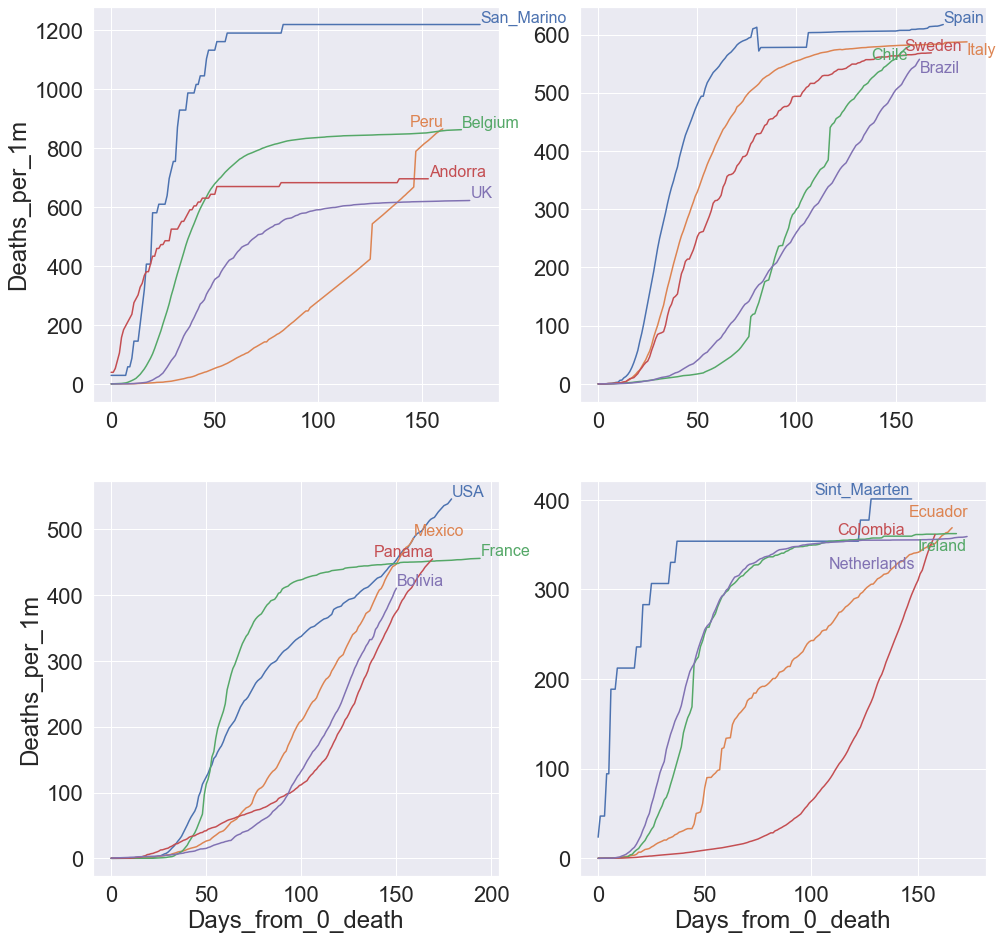

In [8]:
sns.set(rc={'figure.figsize':(16,16)}, font_scale = 2)
fig, axes = plt.subplots(2, 2)

sns.lineplot(x="Days_from_0", y="Deaths_per_1m", hue="Countries", data=data_1_5_deaths, markers=True, hue_order=countries_1_5_deaths, legend=False, ax=axes[0, 0])
texts = [axes[0, 0].text(list(data_1_5_deaths[data_1_5_deaths['Countries']==str(country)]['Days_from_0'])[-1],list(data_1_5_deaths[data_1_5_deaths['Countries']==str(country)]['Deaths_per_1m'])[-1] , str(country), fontsize=16, color=axes[0, 0].get_lines()[countries_1_5_deaths.index(country)].get_c(), ha = 'left', va = 'center') for country in countries_1_5_deaths]
adjust_text(texts)
axes[0, 0].set_ylabel("Deaths_per_1m",fontsize=24)


sns.lineplot(x="Days_from_0", y="Deaths_per_1m", hue="Countries", data=data_6_10_deaths, markers=True, hue_order=countries_6_10_deaths, legend=False, ax=axes[0, 1])
texts = [axes[0, 1].text(list(data_6_10_deaths[data_6_10_deaths['Countries']==str(country)]['Days_from_0'])[-1],list(data_6_10_deaths[data_6_10_deaths['Countries']==str(country)]['Deaths_per_1m'])[-1] , str(country), fontsize=16, color=axes[0, 0].get_lines()[countries_6_10_deaths.index(country)].get_c(), ha = 'left', va = 'center') for country in countries_6_10_deaths]
adjust_text(texts)

sns.lineplot(x="Days_from_0", y="Deaths_per_1m", hue="Countries", data=data_11_15_deaths, markers=True, hue_order=countries_11_15_deaths, legend=False, ax=axes[1, 0])
texts = [axes[1, 0].text(list(data_11_15_deaths[data_11_15_deaths['Countries']==str(country)]['Days_from_0'])[-1],list(data_11_15_deaths[data_11_15_deaths['Countries']==str(country)]['Deaths_per_1m'])[-1] , str(country), fontsize=16, color=axes[0, 0].get_lines()[countries_11_15_deaths.index(country)].get_c(), ha = 'left', va = 'center') for country in countries_11_15_deaths]
adjust_text(texts)
axes[1, 0].set_xlabel("Days_from_0_death",fontsize=24)
axes[1, 0].set_ylabel("Deaths_per_1m",fontsize=24)


sns.lineplot(x="Days_from_0", y="Deaths_per_1m", hue="Countries", data=data_16_20_deaths, markers=True, hue_order=countries_16_20_deaths, legend=False, ax=axes[1, 1])
texts = [axes[1, 1].text(list(data_16_20_deaths[data_16_20_deaths['Countries']==str(country)]['Days_from_0'])[-1],list(data_16_20_deaths[data_16_20_deaths['Countries']==str(country)]['Deaths_per_1m'])[-1] , str(country), fontsize=16, color=axes[0, 0].get_lines()[countries_16_20_deaths.index(country)].get_c(), ha = 'left', va = 'center') for country in countries_16_20_deaths]
adjust_text(texts)
axes[1, 1].set_xlabel("Days_from_0_death",fontsize=24)

axes[0, 1].set_ylabel("",fontsize=24)
axes[1, 1].set_ylabel("",fontsize=24)
axes[0, 0].set_xlabel("",fontsize=24)
axes[0, 1].set_xlabel("",fontsize=24)

plt.savefig('Fig_2_2_ZHANG_YANBIN.png')